In [165]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from audioldm2.latent_diffusion.modules.audiomae.AudioMAE import Vanilla_AudioMAE, AudioMAE
import librosa

In [164]:
def extract_kaldi_fbank_feature(waveform, sampling_rate, log_mel_spec):
    norm_mean = -4.2677393
    norm_std = 4.5689974

    if sampling_rate != 16000:
        waveform_16k = torchaudio.functional.resample(
            waveform, orig_freq=sampling_rate, new_freq=16000
        )
    else:
        waveform_16k = waveform

    waveform_16k = waveform_16k - waveform_16k.mean()
    fbank = torchaudio.compliance.kaldi.fbank(
        waveform_16k,
        htk_compat=True,
        sample_frequency=16000,
        frame_length=25, # 25ms = 400 samples @16kHz
        frame_shift=10, # 10ms = 160 samples @16kHz
        use_energy=False,
        window_type="hanning",
        num_mel_bins=128,
        dither=0.0,
    )

    TARGET_LEN = log_mel_spec.size(0)

    # cut and pad
    n_frames = fbank.shape[0]
    p = TARGET_LEN - n_frames
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[:TARGET_LEN, :]

    fbank = (fbank - norm_mean) / (norm_std * 2)

    return {"ta_kaldi_fbank": fbank}  # [1024 (time), 128 (freq)] 

In [174]:
# extracting checkpoint for audioMAE
checkpoint = torch.load('/root/.cache/huggingface/hub/models--haoheliu--audioldm2-full/snapshots/a1c61356b3b9ecfa534daf5d784a901af463d470/audioldm2-full.pth')
audiomae_ckpt = {}
for i in checkpoint['state_dict'].keys():
    if 'cond_stage_models.0.cond_stage_models.2.audiomae.model.' in i:
        # keep the last three strings after dot
        mae_i = '.'.join(i.split('.')[5:])
        audiomae_ckpt[mae_i] = checkpoint['state_dict'][i]


In [175]:
waveform = torch.randn(2,164080) # (audio channels, audio_length) it doesn't support batch size > 1
output = extract_kaldi_fbank_feature(waveform, 16000, torch.randn(1024,128)) # if the audio is longer than 164080, excessive frames will be cut. If short, pad.
# expected output shape (time, freq) = (1024, 128)

In [176]:
van_audio_mae = Vanilla_AudioMAE()

In [177]:
van_audio_mae.load_state_dict(audiomae_ckpt)

<All keys matched successfully>

In [186]:
x = output['ta_kaldi_fbank'].unsqueeze(0).unsqueeze(0) # converting single audio to batch size 1, channel 1: (1,1,1024,128)
feat = van_audio_mae(x, no_mask=True)

In [192]:
# real audio
waveform, sr = torchaudio.load('mix_16k.wav')
output = extract_kaldi_fbank_feature(waveform, 16000, torch.randn(1024,128))
x = output['ta_kaldi_fbank'].unsqueeze(0).unsqueeze(0) # converting single audio to batch size 1, channel 1: (1,1,1024,128)
feat = van_audio_mae(x, no_mask=True)

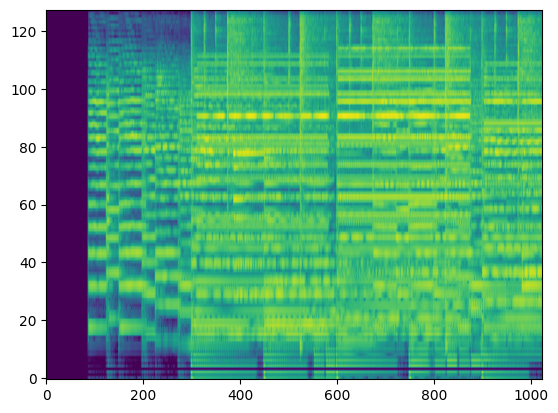

In [193]:
plt.imshow(output['ta_kaldi_fbank'].T, aspect='auto', origin='lower')

In [196]:
feat[0].shape

torch.Size([513, 768])